To read more about kNN search, checkout the [docs](https://www.elastic.co/docs/solutions/search/vector/knn)

## Connect To EasticSearch

In [1]:
from pprint import pprint
from elasticsearch import Elasticsearch

es = Elasticsearch('http://localhost:9200')
client_info = es.info()
print('Connected to Elasticsearch!')
pprint(client_info.body)

Connected to Elasticsearch!
{'cluster_name': 'docker-cluster',
 'cluster_uuid': 'FQt-ffZfTpeh0Snf3pUAQw',
 'name': 'ae8b5b4be42b',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2024-08-05T10:05:34.233336849Z',
             'build_flavor': 'default',
             'build_hash': '1a77947f34deddb41af25e6f0ddb8e830159c179',
             'build_snapshot': False,
             'build_type': 'docker',
             'lucene_version': '9.11.1',
             'minimum_index_compatibility_version': '7.0.0',
             'minimum_wire_compatibility_version': '7.17.0',
             'number': '8.15.0'}}


## Preparing the index

We are adding a new field with type `dense_vector` to store the `embeddings`.



In [2]:
es.indices.delete(index='my_index', ignore_unavailable=True)
es.indices.create(
    index="my_index",
    mappings={
        "properties":{
            "embedding":{
                "type":"dense_vector",
            }
        }
    }
)



ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'my_index'})

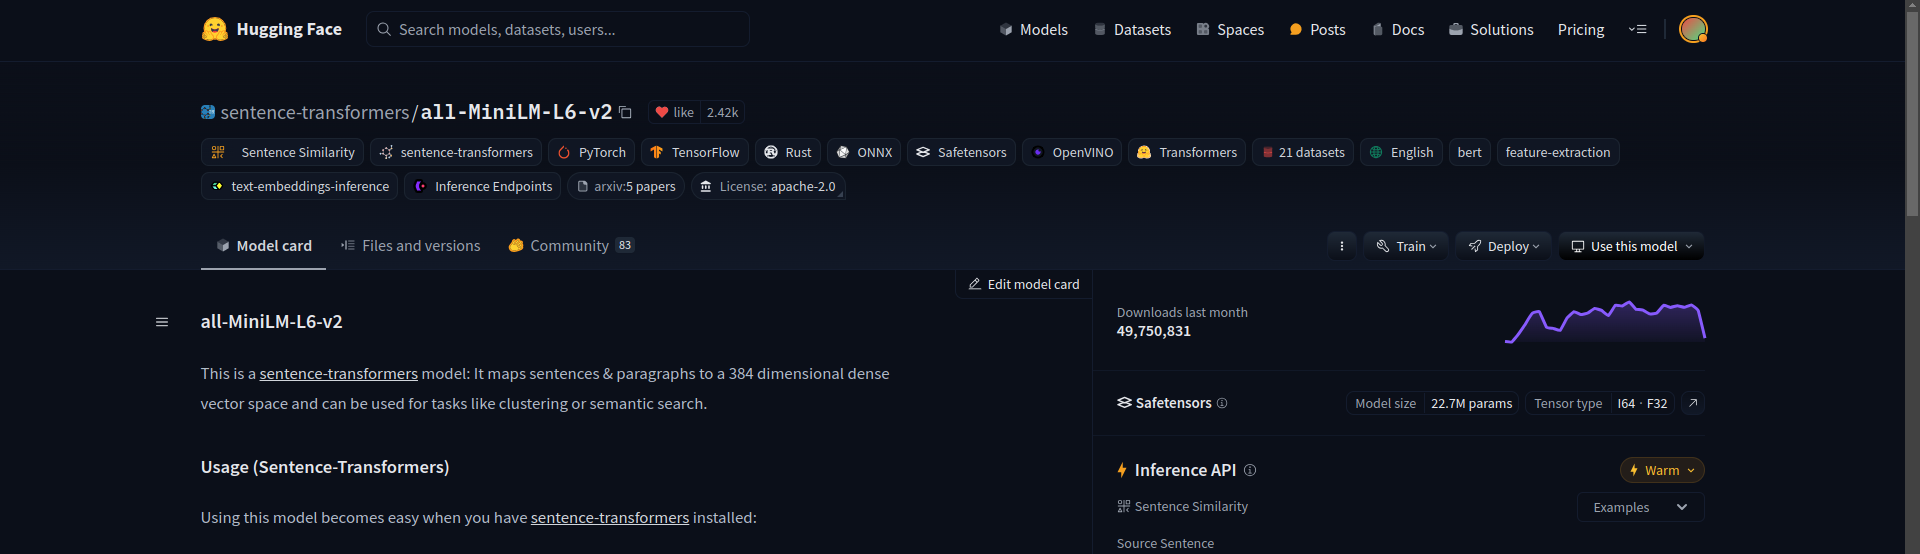

In [3]:
from IPython.display import Image, display

display(Image(filename="../images/all-MiniLM-L6-v2_model.png"))

I chose the a`ll-MiniLM-L6-v2` model for its speed, compact size, and versatility as a general-purpose model. It features an embedding dimension of `384` and truncates text that exceeds `256` words. This model is very popular in the community with almost `50M` downloads in one month.

To download and utilize this model, Hugging Face offers a Python package called `sentence-transformers`. This framework simplifies the process of computing dense vector representations.

In [4]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [5]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [6]:
model = model.to(device)
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False, 'architecture': 'BertModel'})
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

## Load Documents

In [7]:
import json


documents = json.load(open("../data/astronomy.json"))
documents

[{'id': 1,
  'title': 'The Solar System',
  'content': 'The Solar System consists of the Sun and the objects that orbit it, including eight planets, their moons, dwarf planets, and countless small bodies like asteroids and comets.'},
 {'id': 2,
  'title': 'Black Holes',
  'content': 'A black hole is a region of space where the gravitational pull is so strong that nothing, not even light, can escape from it. They are formed when massive stars collapse under their own gravity.'},
 {'id': 3,
  'title': 'Galaxies',
  'content': 'Galaxies are vast systems that consist of stars, stellar remnants, interstellar gas, dust, and dark matter. The Milky Way is the galaxy that contains our Solar System.'},
 {'id': 4,
  'title': 'The Big Bang Theory',
  'content': 'The Big Bang Theory is the leading explanation about how the universe began. It suggests that the universe was once in an extremely hot and dense state and has been expanding ever since.'},
 {'id': 5,
  'title': 'Exoplanets',
  'content': 

## Embed Documents

In [8]:
from tqdm import tqdm
from pprint import pprint


def get_embedding(text):
    return model.encode(text)


operations = []
for document in tqdm(documents, total=len(documents)):
    operations.append({'index': {'_index': 'my_index'}})
    operations.append({
        **document,
        'embedding': get_embedding(document['content']),
    })

response = es.bulk(operations=operations)
pprint(response.body)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 71.42it/s]


{'errors': False,
 'items': [{'index': {'_id': 'Q7FxSJoBesPIpDe2yUsU',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 0,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': 'RLFxSJoBesPIpDe2yUsV',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 1,
                      '_shards': {'failed': 0, 'successful': 1, 'total': 2},
                      '_version': 1,
                      'result': 'created',
                      'status': 201}},
           {'index': {'_id': 'RbFxSJoBesPIpDe2yUsV',
                      '_index': 'my_index',
                      '_primary_term': 1,
                      '_seq_no': 2,
                      '_shards': {'failed': 0, 'successful': 1, '

We indexed all documents with an additional field `embedding`. Let's retrieve the documents to verify that the text was converted to a dense vector.

In [9]:
response = es.search(
    index= "my_index",
    body={
        "query":{
            "match_all":{}
        }
    }
)

pprint(response["hits"]["hits"])

[{'_id': 'Q7FxSJoBesPIpDe2yUsU',
  '_index': 'my_index',
  '_score': 1.0,
  '_source': {'content': 'The Solar System consists of the Sun and the objects '
                         'that orbit it, including eight planets, their moons, '
                         'dwarf planets, and countless small bodies like '
                         'asteroids and comets.',
              'embedding': [0.04063338413834572,
                            -0.0025617294013500214,
                            0.0548347532749176,
                            0.009171068668365479,
                            0.0312199704349041,
                            -0.014487946406006813,
                            0.029695717617869377,
                            0.016134917736053467,
                            0.06336763501167297,
                            0.045461561530828476,
                            -0.003983687609434128,
                            -0.054472632706165314,
                            0.0484162420

Awesome! We successfully inserted the documents with the additional `embedding` field. Now, let’s check the mapping to confirm that the dimension of the dense vector is 384.

In [10]:
response = es.indices.get_mapping(index='my_index')
pprint(response.body)

{'my_index': {'mappings': {'properties': {'content': {'fields': {'keyword': {'ignore_above': 256,
                                                                             'type': 'keyword'}},
                                                      'type': 'text'},
                                          'embedding': {'dims': 384,
                                                        'index': True,
                                                        'index_options': {'ef_construction': 100,
                                                                          'm': 16,
                                                                          'type': 'int8_hnsw'},
                                                        'similarity': 'cosine',
                                                        'type': 'dense_vector'},
                                          'id': {'type': 'long'},
                                          'title': {'fields': {'keyword': {'ignore_above'

## kNN search

### 1. Query N°1

In [12]:
from pprint import pprint

query = "What is black holw?"
embedded_query = get_embedding(query)

result = es.search(
    index= "my_index",
    knn={
        "field":"embedding",
        "query_vector": embedded_query,
        "num_candidates": 5,
        "k":3,
    }
)

n_documents = result.body["hits"]["total"]["value"]
print(f"Found {n_documents} documents")
        

Found 3 documents


In [13]:
hits = result.body["hits"]["hits"]
for hit in hits:
    print(f"Title  : {hit['_source']['title']}")
    print(f"Content: {hit['_source']['content']}")
    print(f"Score  : {hit['_score']}")
    print("*"*100)

Title  : Black Holes
Content: A black hole is a region of space where the gravitational pull is so strong that nothing, not even light, can escape from it. They are formed when massive stars collapse under their own gravity.
Score  : 0.65966654
****************************************************************************************************
Title  : Dark Matter
Content: Dark matter is a type of matter that does not emit light or energy. It cannot be observed directly but is believed to make up about 27% of the universe's total mass and energy.
Score  : 0.58414507
****************************************************************************************************
Title  : The Big Bang Theory
Content: The Big Bang Theory is the leading explanation about how the universe began. It suggests that the universe was once in an extremely hot and dense state and has been expanding ever since.
Score  : 0.5771873
**********************************************************************************

### 2. Query N°2

In [14]:
query = "How do we find exoplanets?"
embedded_query = get_embedding(query)

result = es.search(
    index='my_index',
    knn={
        "field": "embedding",
        "query_vector": embedded_query,
        "num_candidates": 5,
        "k": 1,
    }
)

n_documents = result.body["hits"]["total"]["value"]
print(f"Found {n_documents} documents")

Found 1 documents


In [15]:
hits = result.body["hits"]["hits"]
for hit in hits:
    print(f"Title  : {hit['_source']['title']}")
    print(f"Content: {hit['_source']['content']}")
    print(f"Score  : {hit['_score']}")
    print("*"*100)

Title  : Exoplanets
Content: Exoplanets, or extrasolar planets, are planets that exist outside our solar system. They vary greatly in size and composition and are often found using methods like the transit method and radial velocity.
Score  : 0.85656
****************************************************************************************************
